In [1]:
import sys
sys.path.append('../src')
from data_processing import DataLoader, DataCleaner, EDAProcessor
from geolocation import GeolocationProcessor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
loader = DataLoader("../data/raw/Fraud_Data.csv")
fraud_data = loader.load_data()
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


### Understand and clean the data

In [3]:
cleaner = DataCleaner(fraud_data)

In [4]:
cleaner.data_overview()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [5]:
cleaner.missing_values_summary()

,missing_count,missing_pct
user_id,0,0.0
signup_time,0,0.0
purchase_time,0,0.0
purchase_value,0,0.0
device_id,0,0.0
source,0,0.0
browser,0,0.0
sex,0,0.0
age,0,0.0
ip_address,0,0.0


In [6]:
cleaner.handle_missing_values()

,imputed_values_per_column
user_id,0
purchase_value,0
age,0
ip_address,0
class,0
signup_time,0
purchase_time,0
device_id,0
source,0
browser,0


In [7]:
cleaner.remove_duplicates()

{'duplicates_removed': 0}

In [8]:
cleaner.fix_datetime_columns(["signup_time", "purchase_time"])

,dtype
signup_time,datetime64[ns]
purchase_time,datetime64[ns]


In [9]:
data_cleaned = cleaner.df

Initialize EDAProcessor

In [10]:
eda = EDAProcessor(data_cleaned)

### Univariate Analysis (Distributions of Key Variables)

In [11]:
numerical_cols = ["purchase_value", "age"]  
num_stats = eda.summary_statistics(numerical_cols)
display(num_stats)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
purchase_value,151112.0,36.935372,18.322762,9.0,22.0,35.0,49.0,154.0,0.670485,0.138292
age,151112.0,33.140704,8.617733,18.0,27.0,33.0,39.0,76.0,0.425481,-0.173400


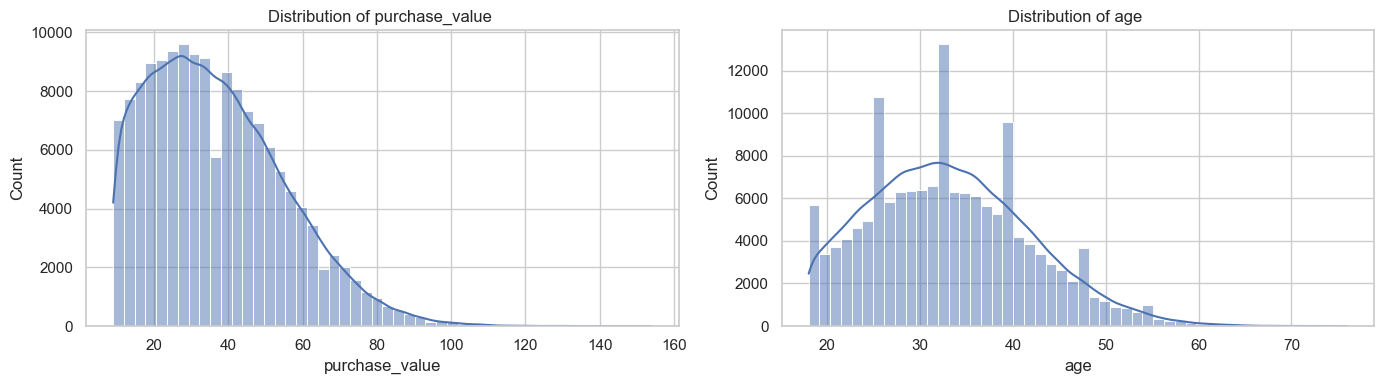

In [12]:
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(14, 4))

for ax, col in zip(axes, numerical_cols):
    sns.histplot(data_cleaned[col], bins=50, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col} ")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()


#### Categorical Features Analysis

,num_categories,top_category_pct,entropy
sex,2.0,0.584288,0.67887
browser,5.0,0.406533,1.39155
source,3.0,0.401126,1.05669


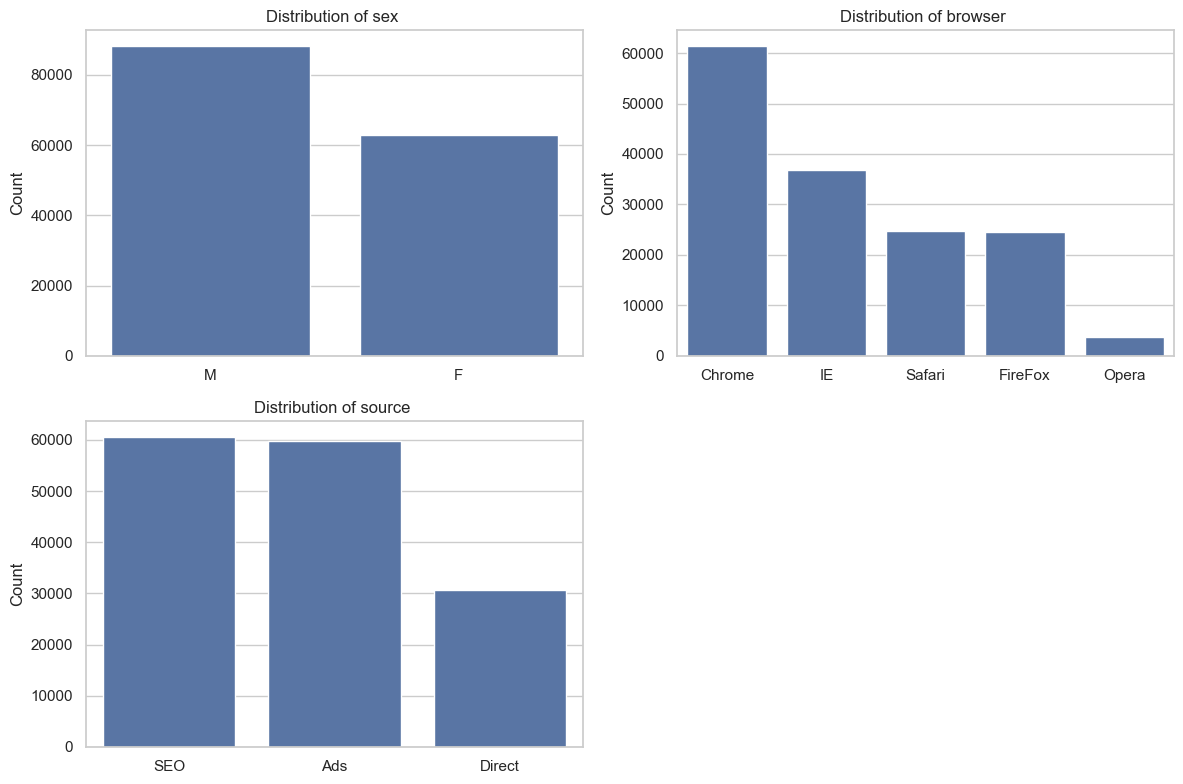

In [13]:
categorical_cols = ["sex", "browser", "source"]

cat_metrics = eda.categorical_metrics(categorical_cols)
display(cat_metrics)

# Plot bar charts
n_cols = 2
n_rows = (len(categorical_cols) + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    counts = data_cleaned[col].value_counts().head(5)
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i])
    axes[i].set_title(f"Distribution of {col} ")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Bivariate Analysis (Features vs Target)

Numerical features vs target

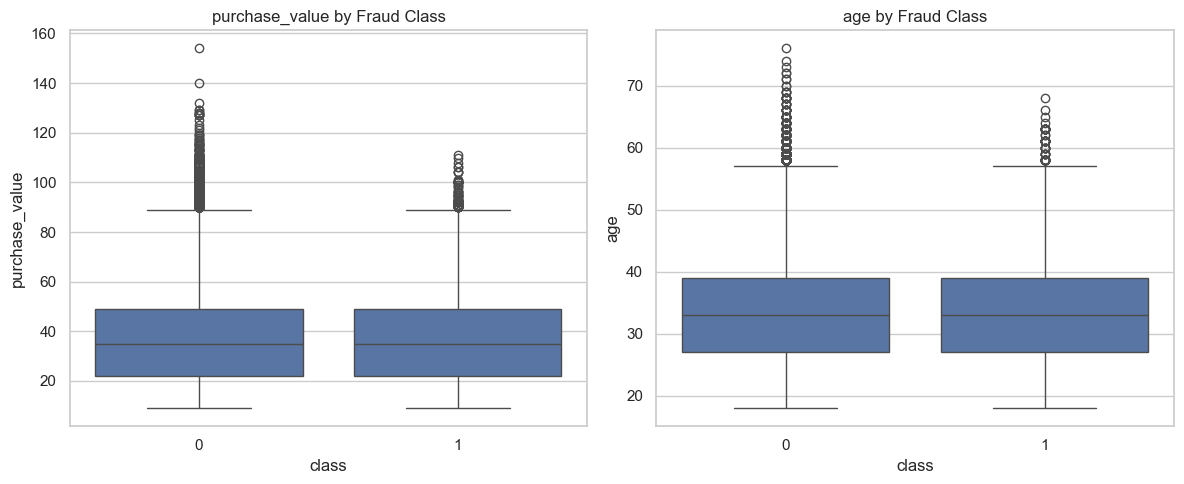

In [14]:
numerical_cols = ["purchase_value", "age"]

# Create subplots
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(12, 5))

for ax, col in zip(axes, numerical_cols):
    sns.boxplot(x="class", y=col, data=data_cleaned, ax=ax)
    ax.set_title(f"{col} by Fraud Class")

plt.tight_layout()
plt.show()


#### Categorical features vs target

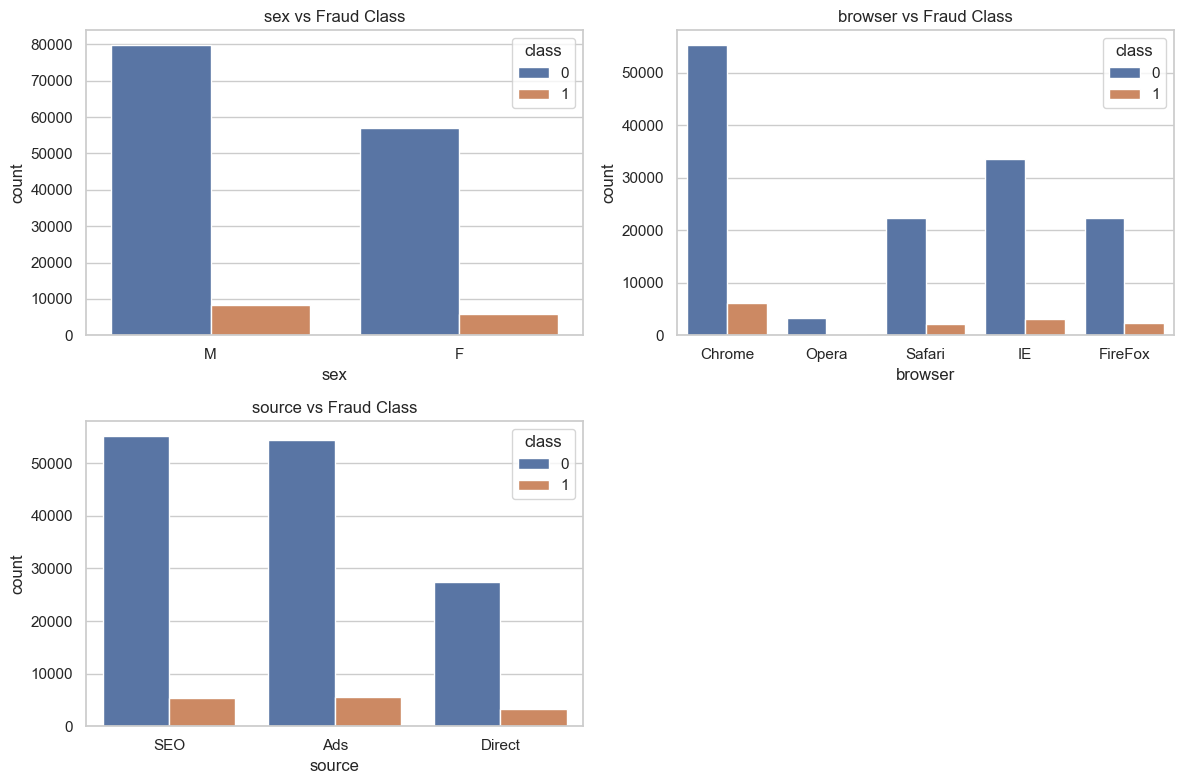

In [15]:
categorical_cols = ["sex", "browser", "source"]

# Determine grid size
n_cols = 2
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # flatten in case of multiple rows

# Plot each countplot
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue="class", data=data_cleaned, ax=axes[i])
    axes[i].set_title(f"{col} vs Fraud Class")

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Class Distribution (Target Variable)

,count,percentage
class,,
0,136961,0.906354
1,14151,0.093646


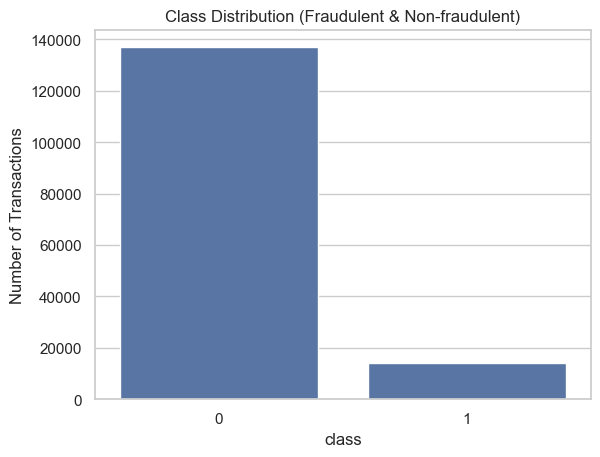

In [16]:
target = "class"
class_dist = eda.class_distribution(target)
display(class_dist)

# Plot
sns.barplot(x=class_dist.index, y=class_dist["count"])
plt.title("Class Distribution (Fraudulent & Non-fraudulent)")
plt.ylabel("Number of Transactions")
plt.show()

## Geolocation Integration

In [17]:
ip_data = DataLoader("../data/raw/IpAddress_to_Country.csv").load_data()
geo = GeolocationProcessor(ip_data)
ip_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [18]:
ip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Convert IP Address Column

In [19]:
data_cleaned["ip_int"] = data_cleaned["ip_address"].astype("int64")

### Map IPs to Countries

In [20]:
data_cleaned["country"] = data_cleaned["ip_int"].apply(geo.map_country)

In [21]:
data_cleaned["country"].value_counts().head(10)

country
United States        58049
Unknown              21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: count, dtype: int64

### Fraud Analysis by Country

In [22]:
country_fraud_rate = (
    data_cleaned
    .groupby("country")["class"]
    .mean()
    .sort_values(ascending=False)
)

display(country_fraud_rate.head(10))

country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

In [27]:
# Calculate both count and mean at the same time
country_stats = data_cleaned.groupby("country")["class"].agg(['count', 'mean'])

reliable_fraud_rates = country_stats[country_stats['count'] > 1000].sort_values(by='mean', ascending=False)

display(reliable_fraud_rates.head(10))

,count,mean
country,,
Mexico,1121,0.128457
Sweden,1090,0.120183
Canada,2975,0.116975
India,1310,0.115267
United Kingdom,4490,0.106236
Japan,7306,0.097865
United States,58049,0.095626
France,3161,0.094907
Korea Republic of,4162,0.091302


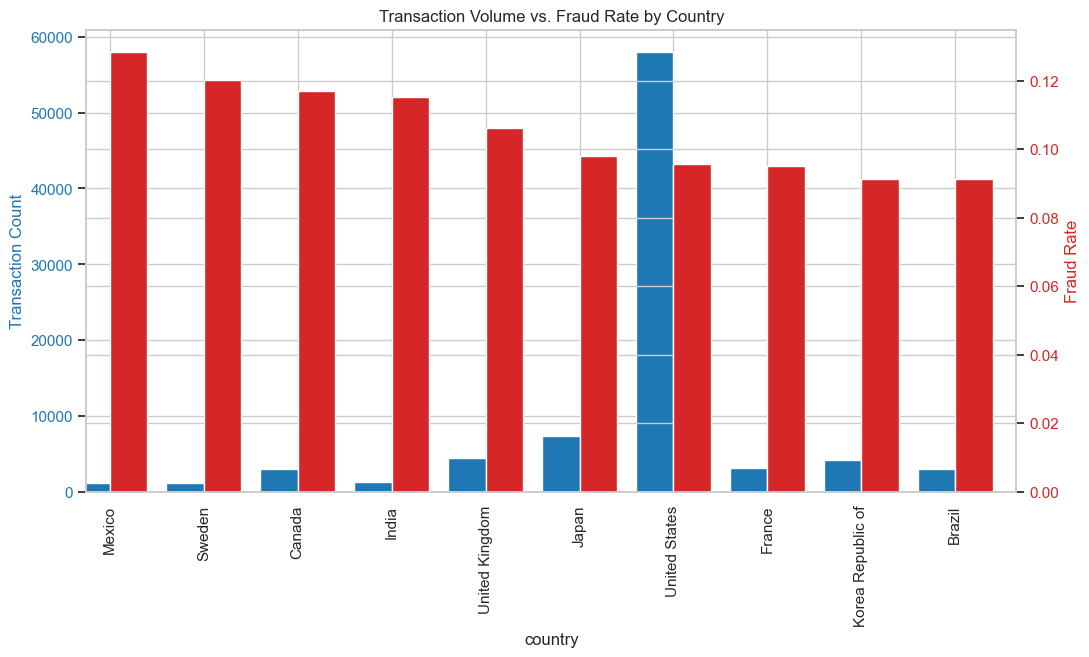

In [28]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Count on the first axis
ax1.set_xlabel('Country')
ax1.set_ylabel('Transaction Count', color='tab:blue')
reliable_fraud_rates['count'].head(10).plot(kind='bar', ax=ax1, position=1, width=0.4, color='tab:blue', label='Count')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin axis for the Fraud Rate
ax2 = ax1.twinx()
ax2.set_ylabel('Fraud Rate', color='tab:red')
reliable_fraud_rates['mean'].head(10).plot(kind='bar', ax=ax2, position=0, width=0.4, color='tab:red', label='Fraud Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Transaction Volume vs. Fraud Rate by Country")
plt.show()

Save the merged data

In [25]:
data_loader = DataLoader()
data_loader.df = data_cleaned 
data_loader.save_data("../data/processed/fraud_data_merged.csv")